<a href="https://colab.research.google.com/github/Kimtaewookdev/Sec1_project/blob/main/AI_13_%EA%B9%80%ED%83%9C%EC%9A%B1_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI_13 Section2 Project 
# League of Legends 승패 예측


> ### 1. 데이터 선정 이유 및 문제 정의


구글링하면서 접하는 LoL 데이터 분석은 인게임 초반 데이터를 통해 승패를 예측하는 사례들이 많았습니다. 이러한 데이터 분석은 승패에 많은 영향을 끼치는 특성을 고려해 게임 플레이를 개선할 수 있다는 점에 의의가 있습니다. 하지만 인게임 초반 데이터는 이미 게임이 시작한 이후 수집되는 것이기에 다음 문제를 해결하는데에는 도움이 되지 않습니다.
   

> 😥 팀운의 문제


LoL은 다섯 명으로 구성된 두 팀이 서로 경쟁하는 게임이기에 자신의 실력이 출중해도 아군의 실력이 상대보다 못하다면 애를 쓰더라도 패배할 가능성이 높습니다. 그렇다면 게임 시작 전에 승패를 예측해서 패할 가능성이 높다면 게임을 애초에 무산시키는 것은 어떨까요?   

LoL의 게임 한 경기는 다음과 같이 이루어집니다. 게임을 원하는 플레이어들이 대기열을 기다려 다섯 씩 두 팀이 구성되면 '밴픽' 과정이 시작됩니다. 이 과정에서 플레이어들은 자신이 플레이할 챔프(캐릭터)를 고르고, 게임 사전 준비를 합니다. 양 팀 플레이어 전원이 챔프를 고르면 20초가 주어지고, 20초가 끝나면 게임이 시작됩니다. 그런데 이 '밴픽' 과정에서 게임 프로그램을 종료하면 게임은 시작하지 않고, 구성된 팀은 해산되고 다시 대기열을 기다려야 합니다.    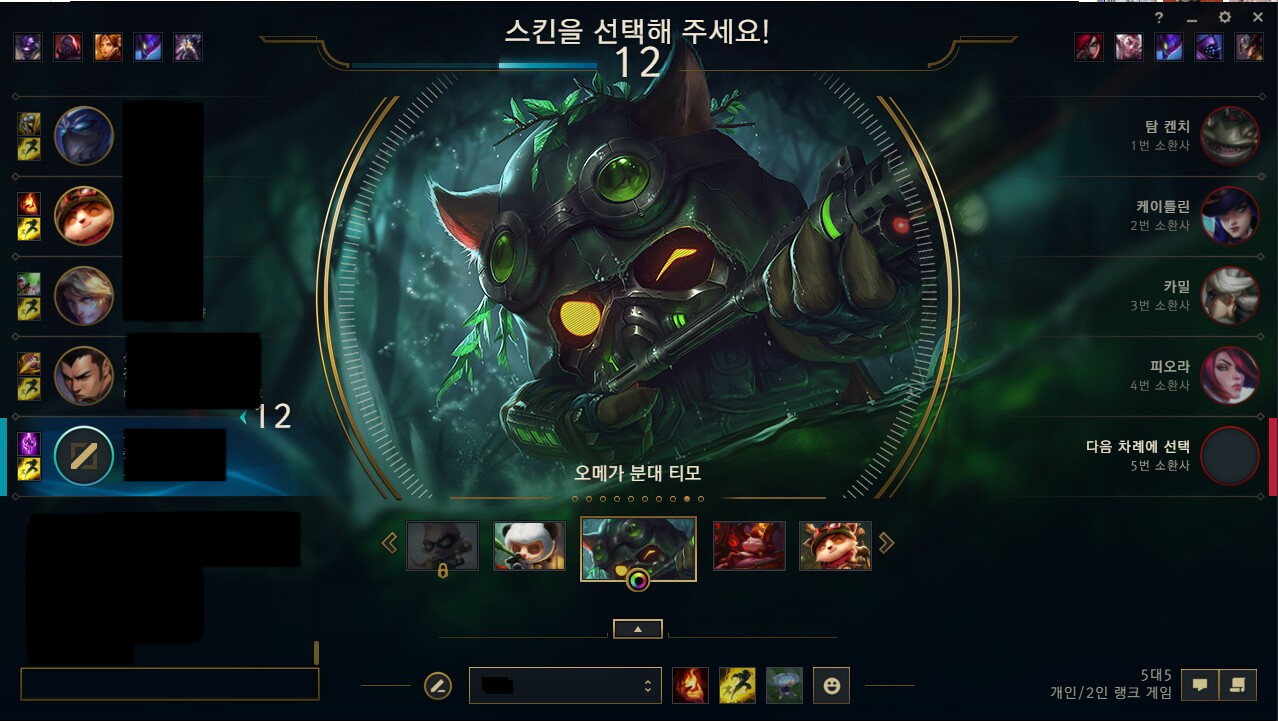


이러한 행위를 닷지라고 하며 24시간 내 횟수에 따라 닷지 후 5분, 30분, 12시간 동안 게임을 플레이할 수 없는 페널티가 있습니다. 하지만 닷지 2회까지는 한 경기에 평균 25분 걸리는 게임의 패배를 피하고 시간을 아낄 수 있다는 메리트가 분명 있습니다.   

게임이 시작하기도 전에 상대가 누군지도 모르는 채로 게임 승패를 예측, 닷지를 활용 할 수 있을까요?


> 구체적인 분석 목표


'밴픽' 과정에서는 아군의 ID 명과 픽한 챔피언 정보를 얻을 수 있습니다. 이것으로 조회할 수 있는 아군 다섯 명의 전적 정보만으로 게임 승패를 예측하는 것입니다.



> 데이터 셋과 가설

https://www.kaggle.com/datasets/dungwoong/lol-s11-challenger-data   
하나의 열이 한 경기의 데이터이고, 10명 전원의 전적 통계 특성과 이긴 팀 특성으로 구성되어 있습니다. 데이터 셋을 EDA로 분석 목표에 맞도록 가공할 것입니다. 종속 변수가 0과 1의 값을 가지는 팀의 승패 특성인 이진 분류 문제입니다.   
플레이어가 선택한 챔프의 숙련도가 중요할 것이라 생각하기 때문에

 "각 포지션 별 챔프 승률이 높을 수록 팀이 승리할 확률이 높을 것이다."   

라는 가설을 시각화를 통해 살펴보겠습니다.



In [ ]:
!pip install category_encoders==2.*
!pip install eli5
!pip install --upgrade pandas-profiling
!pip install pdpbox
!pip install shap
!pip install --upgrade xgboost
!pip install --upgrade jinja2

In [58]:
import xgboost
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas_profiling import profile_report

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from scipy.stats import uniform, randint

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

warnings.filterwarnings("ignore")
xgboost.set_config(verbosity=0)

### 2. EDA

In [74]:
df = pd.read_csv('/content/drive/MyDrive/sec2 ds/lol_na_s11_highelo.csv')

# 불필요 칼럼 제거

dc1 = df.columns[['veteran' in x for x in df.columns]].tolist()
dc2 = df.columns[['inactive' in x for x in df.columns]].tolist()
dc3 = df.columns[['freshblood' in x for x in df.columns]].tolist()
dc4 = df.columns[['hotstreak' in x for x in df.columns]].tolist()
#dc5 = df.columns[['wins' in x for x in df.columns]].tolist()
#dc6 = df.columns[['losses' in x for x in df.columns]].tolist()
#dc7 = df.columns[['avg_game_time' in x for x in df.columns]].tolist()

dc = dc1 + dc2 + dc3 + dc4 #+ dc5 + dc6 + dc7

wr = df.copy()

wr.drop(dc, axis = 1, inplace = True)

In [75]:
# 중복 열 확인
wr.duplicated(['gameid']).value_counts()

False    2088
dtype: int64

In [76]:
wr.drop('gameid', axis = 1, inplace = True)

In [77]:
# 티어, 랭크, lp = lp 포인트로 정리
# 결측치는 Simpleimputer mean으로 처리

def trans_rank(wr):
  team = [100, 200]
  position = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
  for t in team:
    for p in position:
      col = f'{t}_' + p + '_rank'
      wr[col][(wr[col] == 'I')] = -100
      wr[col][(wr[col] == 'II')] = -200
      wr[col][(wr[col] == 'III')] = -300
      wr[col][(wr[col] == 'IV')] = -400
#      wr[col].fillna(0, inplace = True)

def trans_tier(wr):
  team = [100, 200]
  position = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
  for t in team:
    for p in position:
      col = f'{t}_' + p + '_tier'
      wr[col][(wr[col] == 'CHALLENGER')] = 100
      wr[col][(wr[col] == 'GRANDMASTER')] = 100
      wr[col][(wr[col] == 'MASTER')] = 100
      wr[col][(wr[col] == 'DIAMOND')] = 0
      wr[col][(wr[col] == 'PLATINUM')] = -400
      wr[col][(wr[col] == 'GOLD')] = -800
      wr[col][(wr[col] == 'SILVER')] = -1200
#      wr[col].fillna(0, inplace = True)

def trans_lp(wr):
  team = [100, 200]
  position = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
  for t in team:
    for p in position:
      tier = f'{t}_' + p + '_tier'
      rank = f'{t}_' + p + '_rank'
      lp = f'{t}_' + p + '_lp'
#      wr[lp].fillna(0, inplace = True)
      wr[lp] = wr[tier] + wr[rank] + wr[lp]
      wr.drop([tier, rank], axis = 1, inplace = True)

trans_rank(wr)
trans_tier(wr)
trans_lp(wr)

wr.shape

(2088, 171)

In [78]:
# 최근 10 게임 포지션 칼럼을 가장 많이 플레이한 포지션 하나로 정리

def mode_is(list):
  return stats.mode(list)[0][0]

def most_position(wr):
  team = [100, 200]
  position = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
  for t in team:
    for p in position:
      col = f'{t}_' + p + '_positions_played'
      most_col = f'{t}_' + p + '_most_played'
      wr[col] = wr[col].str.split().apply(mode_is)
      wr.rename(columns={col : most_col}, inplace = True)

most_position(wr)

In [79]:
# 데이터를 100(Blue), 200(Red) 팀으로 나누어서 한 팀의 정보만 담은 데이터셋으로 변환

wr_col100 = wr.columns[['100' in x for x in wr.columns]].tolist()
wr_col200 = wr.columns[['200' in x for x in wr.columns]].tolist()

wr_blue = wr[wr_col100].copy()
wr_red = wr[wr_col200].copy()

wt = 'winning_team'

wr_blue[wt] = wr[wt]
wr_red[wt] = wr[wt]

wr_blue['Team'] = 'Blue'
wr_red['Team'] = 'Red'

# 'Result' column은 0 패배 1 승리

wr_blue['Result'] = 0
wr_blue['Result'][wr_blue[wt] == 100] = 1

wr_red['Result'] = 0
wr_red['Result'][wr_red[wt] == 200] = 1

wr_blue.drop(wt, axis = 1, inplace = True)
wr_red.drop(wt, axis = 1, inplace = True)

In [80]:
# colunm 명 변경

def remove_100(x):
  if '100' in x:
    x.remove('100')
  str = '_'.join(x)
  return str

col_united = wr_blue.columns.str.split('_').map(remove_100)

wr_blue.columns = col_united
wr_red.columns = col_united

# 병합

qw = pd.concat([wr_blue, wr_red], ignore_index=True)

In [81]:
# 플레이어가 한 번도 해당 포지션을 해본 적이 없는 경우 게임 수, 승률 0 으로 처리
# 처음 하는 챔피언의 승률 0 으로 처리 (champ_games_played = 0 일때 champ_winrate가 결측치)

#na_qw = qw[qw.columns[['champ' in x for x in qw.columns]]]
#na_col = na_qw.isna().sum(axis = 1)[na_qw.isna().sum(axis = 1) != 0].index
#na_qw.iloc[na_col]

qw_col_role = qw.columns[['role' in x for x in qw.columns]].tolist()
qw_col_champ = qw.columns[['champ' in x for x in qw.columns]].tolist()

for col in qw_col_role + qw_col_champ:
  qw[col].fillna(0, inplace = True)

In [85]:
# 플레이어의 종합 승률, 판수

def total(qw):
  position = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
  for p in position:
    win = p + '_wins'
    lose = p + '_losses'
    total = p + '_total_played'
    total_wr = p + '_total_wr'
    qw[total] = qw[win] + qw[lose]
    qw[total_wr] = qw[win] / qw[total]
    qw.drop([win, lose], axis= 1, inplace= True)

total(qw)

qw.TOP_total_wr.isna().value_counts()

False    3926
True      250
Name: TOP_total_wr, dtype: int64

In [86]:
# 이상치 처리, 평균 게임 시간, 평균 분당 골드획득량에 확실한 이상치 존재
# 게임 시간에는 80분 이상의 데이터, 골드획득량은 기본 획득량이 있음에도 100G 이하의 획득량
# 분당 가한 피해량, 오브젝트 피해량의 경우 지나치게 작은 데이터가 있지만 해당 플레이어들의 lp가 낮아 이상치가 아니라고 판단
# 고의로 트롤링하는 유저의 가능성이 있음.
# 결측치로 처리해서 SimpleImputer로 mean으로 채움.

def outlier_remove(qw):
  position = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
  for p in position:
    time = p + '_avg_game_time'
    gold = p + '_goldpm'
    qw[time][qw[time] > 80] = np.nan
    qw[gold][qw[gold] < 100] = np.nan

outlier_remove(qw)

qw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 87 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TOP_avg_game_time           4142 non-null   float64
 1   TOP_most_played             4176 non-null   object 
 2   TOP_avg_kda                 4176 non-null   float64
 3   TOP_avg_kp                  4176 non-null   float64
 4   TOP_avg_vision              4176 non-null   float64
 5   TOP_avg_cs                  4176 non-null   float64
 6   TOP_goldpm                  4142 non-null   float64
 7   TOP_dmgpm                   4176 non-null   float64
 8   TOP_dmg_to_obj_pm           4176 non-null   float64
 9   TOP_wr                      4176 non-null   float64
 10  TOP_lp                      3926 non-null   object 
 11  TOP_role_total_played       4176 non-null   float64
 12  TOP_role_wr                 4176 non-null   float64
 13  TOP_champ_games_played      4176 

In [153]:
# Data Leakage 가능성, 플레이어의 전적 데이터가 실시간 집계가 아니라면 이미 통계에 승리가 반영되어있을 수 있다.
# 해당 게임 결과 이후에 수집된, 게임 결과가 반영된 전적 데이터 일 수도 있다.
# 특히 챔프 플레이 경기 수가 한 판 뿐인 경우는 승리 확률 데이터가 그대로 경기 승패 결과가 된다.
# 챔프 판 수 1 인 플레이어들을 전부 0, 승률도 0으로 처리. 

qw.UTILITY_champ_games_played[qw.UTILITY_champ_games_played < 2]

def no_one(qw):
  position = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
  for p in position:
    champ_game = p + '_champ_games_played'
    champ_wr = p + '_champ_winrate'
    qw[champ_game][qw[champ_game] == 1] = 0
    qw[champ_wr][qw[champ_game] == 0] = 0

no_one(qw)

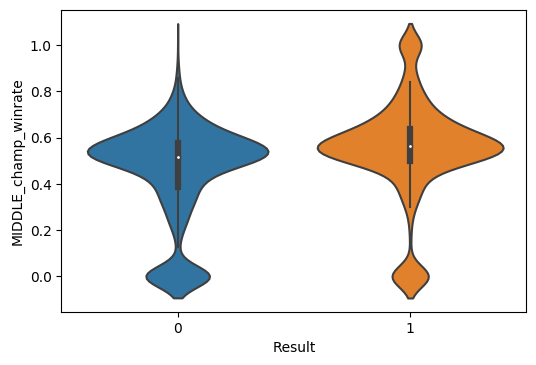

In [172]:
# 시각화
plt.rcParams['figure.dpi'] = 100

sns.violinplot(y = qw.MIDDLE_champ_winrate, x = qw.Result)

plt.show()

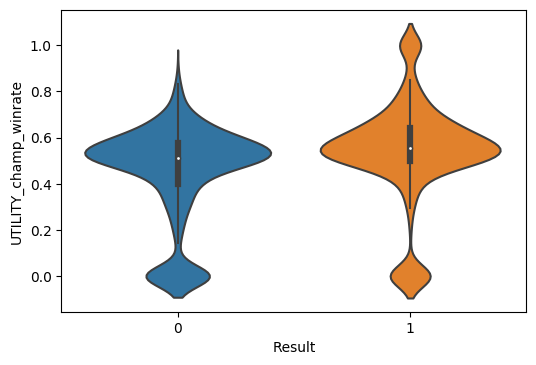

In [171]:
plt.rcParams['figure.dpi'] = 100

sns.violinplot(y = qw.UTILITY_champ_winrate, x = qw.Result)

plt.show()

In [11]:
#pr = qw.profile_report()
#pr.to_file('pr_report.html')

In [154]:
# 훈련 데이터, 테스트 데이터 분리

target = 'Result'

X = qw.drop(target, axis = 1)
y = qw[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train.shape

(3340, 86)

### 3. 모델링 및 모델 해석

In [155]:
# baseline = 0, score = 0.501796 

y_train.value_counts(normalize = True)

1    0.501796
0    0.498204
Name: Result, dtype: float64

In [15]:
## RandomForest

# pipe = make_pipeline(
#     OrdinalEncoder()
#     , SimpleImputer(strategy='mean')
#     , RandomForestClassifier(n_estimators=500, n_jobs=-1)
# )

# dists = {
#     'randomforestclassifier__max_features': uniform(0, 1)
#     , 'randomforestclassifier__min_samples_leaf': randint(1,30)
#     }

# clf = RandomizedSearchCV(
#     estimator = pipe
#     , param_distributions = dists
#     , scoring='accuracy'
#     , cv = 4
#     , n_iter = 50
#     , n_jobs = -1
#     )

# clf.fit(X_train, y_train)
# print("최적 파라미터 :", clf.best_params_)
# print("정확도 :", clf.best_score_)

# model = clf.best_estimator_

# y_pred = model.predict(X_test)

# print(classification_report(y_test, y_pred))

In [156]:
# xgboost

X_xgb, X_val, y_xgb, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

preprocess = make_pipeline(
    OrdinalEncoder()
    , SimpleImputer(strategy='median')
)

X_xgb_pre = preprocess.fit_transform(X_xgb)
X_val_pre = preprocess.transform(X_val)
X_test_pre = preprocess.transform(X_test)

eval_set = [(X_xgb_pre, y_xgb), (X_val_pre, y_val)]

model_xgb = XGBClassifier(n_estimators = 5000
                          , verbosity = 0
                          , objective = 'binary:logistic'
#                          , tree_method='gpu_hist'
#                          , gpu_id=0
#                          , sub_sample = 0.7
#                          , sampling_method = 'gradient_based'
                          , learning_rate = 0.05
                          , max_depth = 4
                          , min_child_weight = 3
                          , n_jobs = -1
                          , colsample_bytree = 0.7
                          , reg_lambda = 0.1
                          , reg_alpha = 0.8
                          , min_split_loss = 5
                          )

param_grid = {
    'sub_sample' : [1]
#    'reg_lambda' : [0, 0.1, 0.2]
    # 'reg_alpha' : [0.7, 0.8, 0.9]
    # , 'min_split_loss' : [3, 4, 5, 6, 7]
  #  'colsample_bytree' : [0.65, 0.7, 0.75]
  #  'learning_rate' : [0.03, 0.04, 0.05, 0.06]
  #  , 'max_depth' : [2, 3, 4, 5]
  #  , 'min_child_weight' : [2, 3, 4, 5, 6]
              }
 


fit_params = {'eval_set' : eval_set
              , 'eval_metric' : 'error'
              , 'early_stopping_rounds' : 100
              , 'verbose' : 0
              }

gcv = GridSearchCV(model_xgb, param_grid = param_grid, cv = 5, n_jobs= -1)

gcv.fit(X_xgb_pre, y_xgb, **fit_params)

#model_xgb.fit(X_xgb_pre, y_xgb, eval_set=eval_set, eval_metric='error', early_stopping_rounds = 100)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=3,
                                     min_split_loss=5, missing=nan,
                    

In [157]:
model_xgb_best = gcv.best_estimator_

print(gcv.best_params_)

y_pred_xgb = model_xgb_best.predict(X_test_pre)

print(classification_report(y_test, y_pred_xgb))

{'sub_sample': 1}
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       424
           1       0.78      0.75      0.76       412

    accuracy                           0.77       836
   macro avg       0.77      0.77      0.77       836
weighted avg       0.77      0.77      0.77       836



In [158]:
# permutation importance

permuter = PermutationImportance(estimator= model_xgb_best, scoring = 'accuracy', n_iter=30)

permuter.fit(X_test_pre, y_test)

eli5.show_weights(
    permuter, 
    top=20,
    feature_names=X_test.columns.tolist()
)

Weight,Feature
0.0298 ± 0.0156,UTILITY_champ_winrate
0.0285 ± 0.0194,JUNGLE_champ_winrate
0.0284 ± 0.0131,TOP_champ_winrate
0.0283 ± 0.0154,MIDDLE_champ_winrate
0.0161 ± 0.0150,BOTTOM_champ_winrate
0.0110 ± 0.0090,MIDDLE_role_wr
0.0104 ± 0.0142,UTILITY_wr
0.0102 ± 0.0137,JUNGLE_wr
0.0090 ± 0.0114,MIDDLE_wr
0.0082 ± 0.0110,BOTTOM_wr


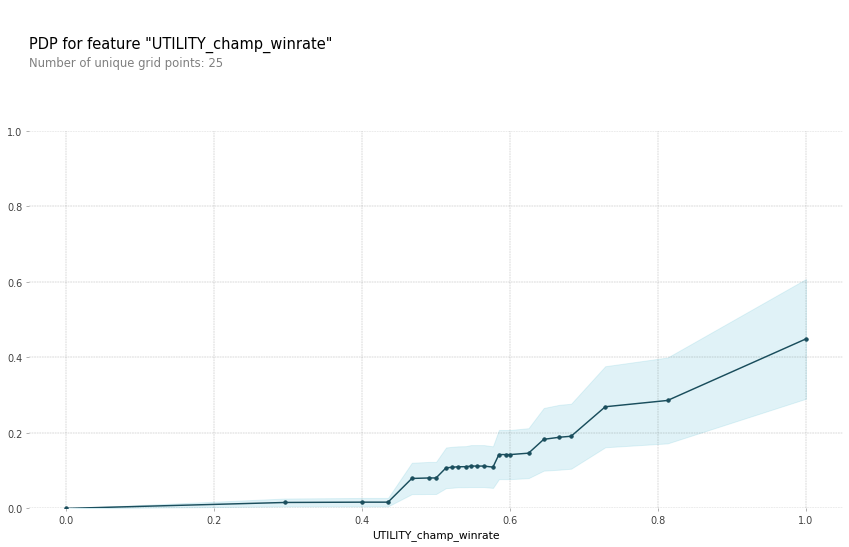

In [159]:
X_test_df = pd.DataFrame(data = X_test_pre, columns= X_test.columns)

plt.rcParams['figure.dpi'] = 70

isolated = pdp_isolate(model= model_xgb_best,
                       dataset= X_test_df,
                       model_features= X_test_df.columns,
                       feature= 'UTILITY_champ_winrate',
                       num_grid_points= 30)

pdp_plot(isolated, feature_name= 'UTILITY_champ_winrate')
plt.ylim(0, 1)
plt.show()

In [160]:
explainer = shap.TreeExplainer(model_xgb_best)

X_test_df = pd.DataFrame(data = X_test_pre, columns= X_test.columns)

row = X_test_df.iloc[[400]]

shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
    )

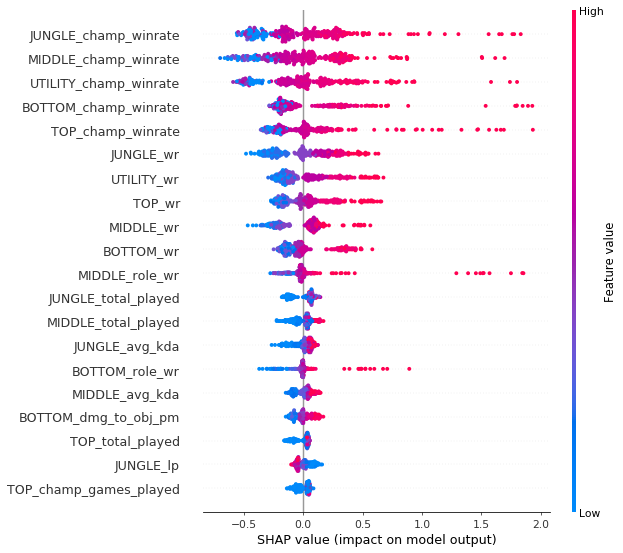

In [161]:
shap.initjs()
shap_values = explainer.shap_values(X_test_df.iloc[:300])
shap.summary_plot(shap_values, X_test_df.iloc[:300])